In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/BrainTumourSegmentation/archive

/content/drive/MyDrive/BrainTumourSegmentation/archive


In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import PIL
import os
import pathlib
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

In [6]:
import glob
from tensorflow.keras.models import Sequential

In [7]:
from keras.models import Sequential,Model,load_model

In [8]:
from keras.layers import Input,Add,Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,AveragePooling2D,MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout

In [9]:
data_dir="/content/drive/MyDrive/BrainTumourSegmentation/archive/brain_tumor_dataset"
data_dir=pathlib.Path(data_dir)

In [10]:
image1=glob.glob("/content/drive/MyDrive/BrainTumourSegmentation/archive/brain_tumor_dataset/*/*.JPG")
image2=glob.glob("/content/drive/MyDrive/BrainTumourSegmentation/archive/brain_tumor_dataset/*/*.jpg")
image=image1+image2
print("Total Number of images:",len(image))

image=pd.Series(image)

Total Number of images: 248


In [11]:
df=pd.DataFrame()
df['filename']=image.map(lambda img_name:img_name.split("/")[-1])
df["ClassID"]=image.map(lambda img_name:img_name.split("/")[-2])
df.head()

,filename,ClassID
0,Y115.JPG,yes
1,Y116.JPG,yes
2,Y112.JPG,yes
3,Y114.JPG,yes
4,Y100.JPG,yes


In [12]:
df['ClassID'].value_counts()

yes    157
no      91
Name: ClassID, dtype: int64

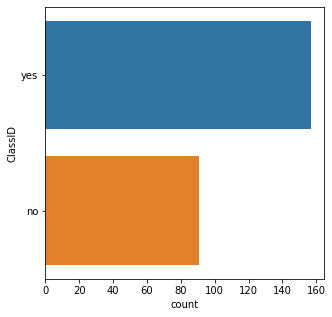

In [13]:
plt.figure(figsize=(5,5))
sns.countplot(y=df['ClassID'])
plt.show()

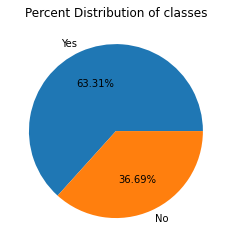

In [14]:
plt.pie(df["ClassID"].value_counts(),labels=['Yes','No'],autopct='%0.2f%%')
plt.title("Percent Distribution of classes")
plt.show()


In [15]:
import splitfolders
splitfolders.ratio(data_dir,output="output",seed=101,ratio=(0.8,0.1,0.1))

Copying files: 256 files [01:31,  2.81 files/s]


In [16]:
train_path="./output/train/"
val_path="./output/val/"
test_path="./output/test"
class_name=os.listdir(train_path)
class_name_val=os.listdir(val_path)
class_name_test=os.listdir(test_path)

In [17]:
train_images1=glob.glob("./output/train/*/*.JPG")
train_images2=glob.glob("./output/train/*/*.jpg")
train_images=train_images1+train_images2
print("No of train images",len(train_images))

test_images1=glob.glob("./output/test/*/*.JPG")
test_images2=glob.glob("./output/test/*/*.jpg")
test_images=test_images1+test_images2
print("No. of test images",len(test_images))


val_images1=glob.glob("./output/val/*/*.JPG")
val_images2=glob.glob("./output/val/*/*.jpg")
val_images=val_images1+val_images2
print("No. of val images",len(val_images))

No of train images 196
No. of test images 28
No. of val images 24


In [18]:
train_img=pd.Series(train_images)
train_df=pd.DataFrame()
train_df["filename"]=train_img.map(lambda img_name:img_name.split("/")[-1])
train_df["ClassID"]=train_img.map(lambda img_name:img_name.split("/")[-2])
train_df.head()

,filename,ClassID
0,Y161.JPG,yes
1,Y109.JPG,yes
2,Y49.JPG,yes
3,Y160.JPG,yes
4,Y155.JPG,yes


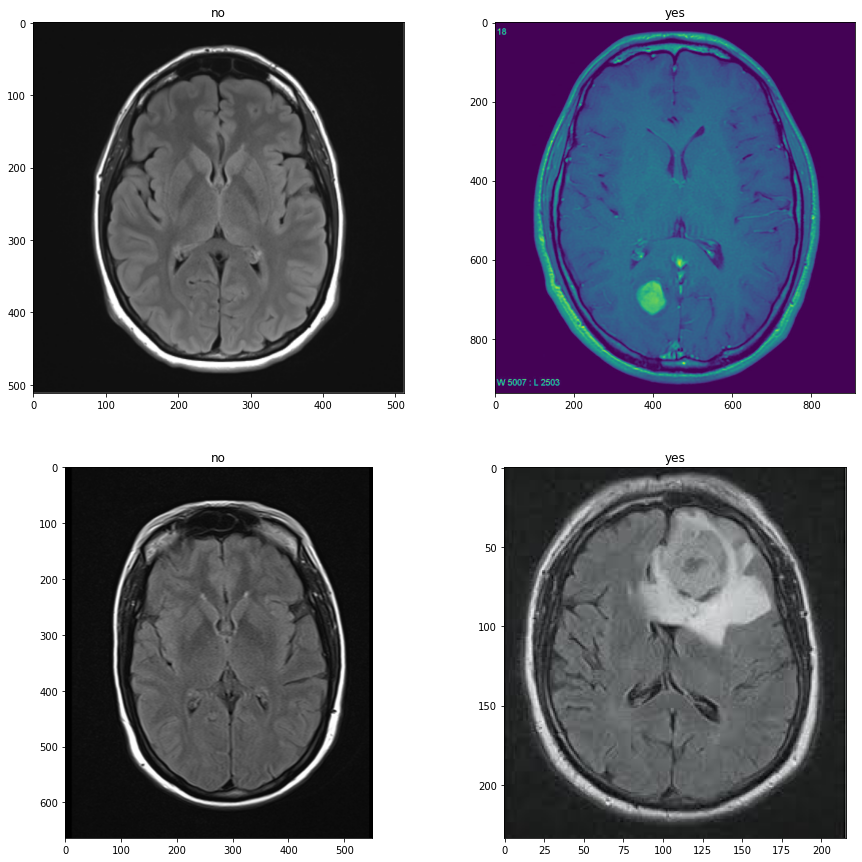

In [19]:
plot_df=train_df.sample(6).reset_index()
plt.figure(figsize=(15,15))

for i in range(4):
    img_name=plot_df.loc[i,'filename']
    label_str=(plot_df.loc[i,"ClassID"])
    plt.subplot(2,2,i+1)
    plt.imshow(plt.imread(os.path.join(train_path,label_str,img_name)))
    plt.title(label_str)

In [20]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_path,target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_path,target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 204 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [21]:
from tensorflow.keras.applications import ResNet50

In [22]:
model=ResNet50(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

94781440/94765736 [==============================] - 1s 0us/step


In [23]:
for layers in model.layers:
    layers.trainable=False

In [24]:
from keras.layers import Dropout

In [25]:
x=Flatten()(model.output)
x=Dropout(0.5)(x)
x=Dense(1,activation='sigmoid')(x)


model=keras.Model(model.input,x)
model.compile(loss="binary_crossentropy",optimizer="adam",metrics="accuracy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [26]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [27]:
es=EarlyStopping(monitor="val_accuracy",mode="max",verbose=1,patience=20)
mc=ModelCheckpoint('./output/model.h5', monitor='val_accuracy', mode='max')


In [28]:
H = model.fit(train_generator,validation_data=val_generator,epochs=150,verbose=1, callbacks=[mc,es])

Epoch 1/150
7/7 [==============================] - 51s 7s/step - loss: 4.6369 - accuracy: 0.5588 - val_loss: 2.2330 - val_accuracy: 0.7500
Epoch 2/150
7/7 [==============================] - 42s 6s/step - loss: 1.7922 - accuracy: 0.8186 - val_loss: 1.0878 - val_accuracy: 0.8333
Epoch 3/150
7/7 [==============================] - 40s 6s/step - loss: 1.5188 - accuracy: 0.8039 - val_loss: 2.6021 - val_accuracy: 0.8750
Epoch 4/150
7/7 [==============================] - 41s 6s/step - loss: 1.2703 - accuracy: 0.8382 - val_loss: 1.4116 - val_accuracy: 0.8750
Epoch 5/150
7/7 [==============================] - 42s 6s/step - loss: 0.5050 - accuracy: 0.9069 - val_loss: 1.4642 - val_accuracy: 0.8750
Epoch 6/150
7/7 [==============================] - 43s 6s/step - loss: 0.7384 - accuracy: 0.9020 - val_loss: 1.8026 - val_accuracy: 0.8750
Epoch 7/150
7/7 [==============================] - 40s 6s/step - loss: 0.8389 - accuracy: 0.9216 - val_loss: 1.8486 - val_accuracy: 0.8333
Epoch 8/150
7/7 [==========

In [29]:
hist=H.history

Text(0, 0.5, 'accuracy')

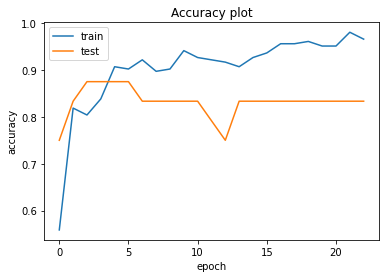

In [30]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

Text(0, 0.5, 'loss')

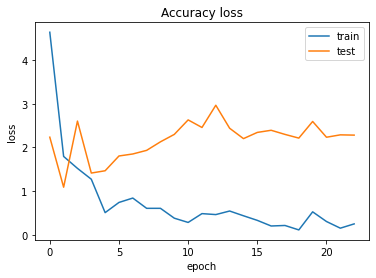

In [31]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")

In [32]:
test_loss,test_acc=model.evaluate(test_generator,steps=len(test_generator),verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

1/1 [==============================] - 5s 5s/step - loss: 1.6876 - accuracy: 0.8571
Loss: 168.756
Accuracy: 85.714


In [33]:
from sklearn.metrics import classification_report

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
y_val=test_generator.classes
y_pred=model.predict(test_generator)
y_pred=np.argmax(y_pred,axis=1)

In [36]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56        11
           1       0.00      0.00      0.00        17

    accuracy                           0.39        28
   macro avg       0.20      0.50      0.28        28
weighted avg       0.15      0.39      0.22        28



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
class_indices=test_generator.class_indices
indices={v:k for k,v in class_indices.items()}

In [38]:
filenames=test_generator.filenames

In [39]:
val_df=pd.DataFrame()
val_df['filname']=filenames
val_df['actual']=y_val
val_df['pred']=y_pred
val_df['actual']=val_df['actual'].apply(lambda x: indices[x])
val_df['pred']=val_df['pred'].apply(lambda x:indices[x])
val_df.head()

,filname,actual,pred
0,no/15 no.jpg,no,no
1,no/32 no.jpg,no,no
2,no/35 no.jpg,no,no
3,no/36 no.jpg,no,no
4,no/6 no.jpg,no,no


In [40]:
print(confusion_matrix(y_val,y_pred))

[[11  0]
 [17  0]]


In [41]:
from tensorflow.keras.preprocessing.image import array_to_img,img_to_array,load_img
img_size=224
def readImage(path):
    img=load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img=img_to_array(img)
    img=img/255
    
    return img

def display_images(temp_df):
    temp_df=temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n=0
    for i in range(6):
        n+=1
        plt.subplot(3,3,n)
        plt.subplots_adjust(hspace=0.5,wspace=0.3)
        image=readImage(f"/content/drive/MyDrive/BrainTumourSegmentation/archive/brain_tumor_dataset/{temp_df.filname[i]}")
        plt.imshow(image)
        plt.title(f'A:{temp_df.actual[i]} P:{temp_df.pred[i]}')
    

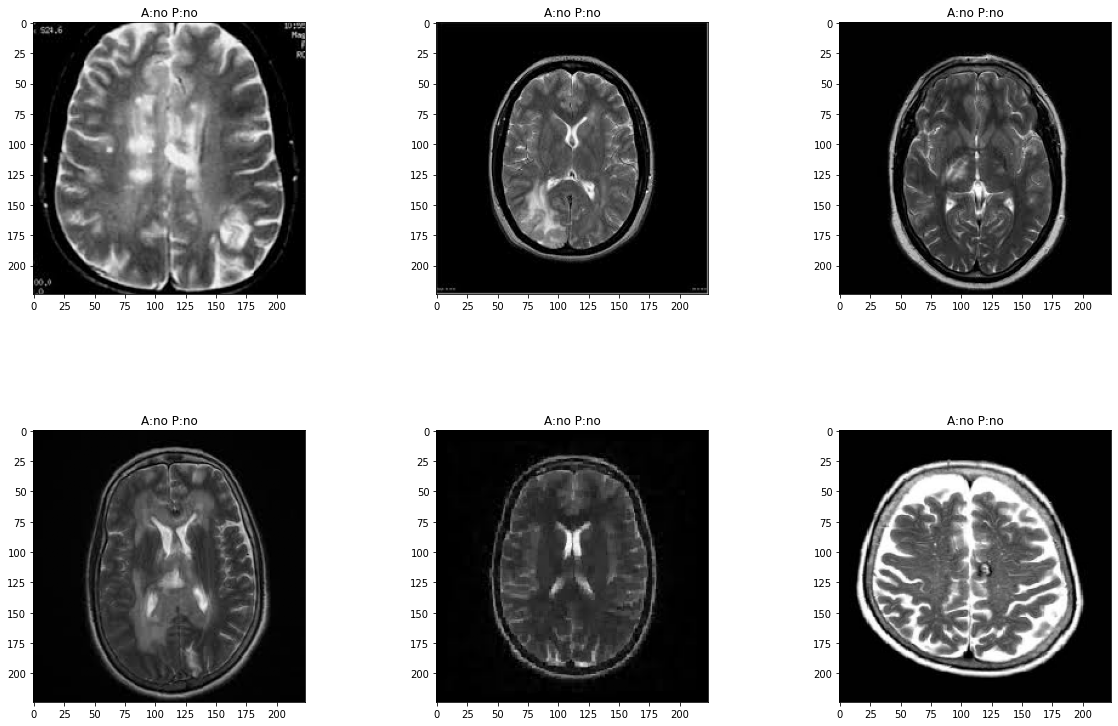

In [42]:
display_images(val_df)